In [2]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 
from scipy.stats import spearmanr
import h5py

import sys 
sys.path.append('./src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from AE import AE
from LogisticRegression import LogisticRegression
from EmbEst import EmbEst
from NNEst import NNEst
from CNN import CNN
import similarities 
import DShap
from LOO import LOO
from sklearn.utils.class_weight import compute_class_weight
from utils import load_data, get_filtered_scores

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
osig = pd.read_csv('./data/processed/ordered_siginfo.tsv', sep='\t')
osig.head()

/tmp/ipykernel_290/4114544458.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  osig = pd.read_csv('./data/processed/ordered_siginfo.tsv', sep='\t')


,sig_id,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,...,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig,APC
0,ABY001_A375_XH:BRD-A61304759:0.625:24,b15,0.66,0.625,uM,0.66 uM,24 h,24.0,h,A375,...,H15|H23,ABY001_A375_XH_X1_B15,ABY001_A375_XH_X1_B15:H15|ABY001_A375_XH_X1_B1...,NaN,ABY,tanespimycin,0.0,1.0,0.0,0.263963
1,ABY001_A375_XH:BRD-A61304759:0.625:3,b15,0.66,0.625,uM,0.66 uM,3 h,3.0,h,A375,...,P03|P07|P11,ABY001_A375_XH_X1_B15,ABY001_A375_XH_X1_B15:P03|ABY001_A375_XH_X1_B1...,NaN,ABY,tanespimycin,0.0,1.0,0.0,0.126818
2,ABY001_A375_XH:BRD-A61304759:10:24,b15,10.00,10.000,uM,10 uM,24 h,24.0,h,A375,...,H13|H17|H21,ABY001_A375_XH_X1_B15,ABY001_A375_XH_X1_B15:H13|ABY001_A375_XH_X1_B1...,NaN,ABY,tanespimycin,0.0,1.0,0.0,0.545588
3,ABY001_A375_XH:BRD-A61304759:10:3,b15,10.00,10.000,uM,10 uM,3 h,3.0,h,A375,...,P01|P05|P09,ABY001_A375_XH_X1_B15,ABY001_A375_XH_X1_B15:P01|ABY001_A375_XH_X1_B1...,NaN,ABY,tanespimycin,0.0,1.0,0.0,0.253248
4,ABY001_A375_XH:BRD-A61304759:2.5:24,b15,2.50,2.500,uM,2.5 uM,24 h,24.0,h,A375,...,H14|H18|H22,ABY001_A375_XH_X1_B15,ABY001_A375_XH_X1_B15:H14|ABY001_A375_XH_X1_B1...,NaN,ABY,tanespimycin,0.0,1.0,0.0,0.537649


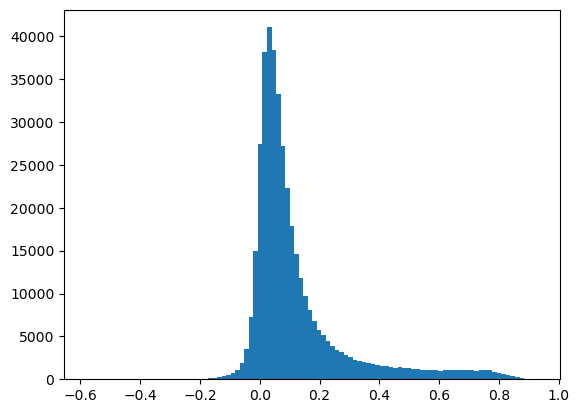

In [4]:
plt.figure()
plt.hist(osig.APC, bins=100)
plt.show()

In [67]:
x_train, y_train, x_valid, y_valid, x_test, y_test, exog_noise, endog_noise, kwargs = load_data(dataset     = 'lincs-hi-apc', 
                                                                                                train_num   = 1000, 
                                                                                                valid_num   = 1000, 
                                                                                                exog_noise  = 3., 
                                                                                                endog_noise = 0., 
                                                                                                lincs_dir   = './data/processed/',
                                                                                                save_dir    = './data/example/', 
                                                                                                clean_up    = True)

print('train size:', x_train.size(), y_train.size(), x_train.dtype)                                                                                        
print('valid size:', x_valid.size(), y_valid.size(), x_train.dtype)                                                                                        
print('test size:', x_test.size(), y_test.size(), x_train.dtype)    

total # samples in high APC subset: 23430
train size: torch.Size([1000, 978]) torch.Size([1000, 978]) torch.float32
valid size: torch.Size([1000, 978]) torch.Size([1000, 978]) torch.float32
test size: torch.Size([21430, 978]) torch.Size([21430, 978]) torch.float32


In [69]:
model = AE(in_channels      = x_train.size(1), 
           num_layers       = 1, 
           hidden_channels  = 500, 
           latent_channels  = 50,
           norm             = True, 
           dropout          = 0.05, 
           bias             = True, 
           act              = torch.nn.Mish)

In [70]:
dvgs = DVGS(x_source         = x_train,
            y_source         = y_train, 
            x_target         = x_valid,  
            y_target         = y_valid, 
            model            = copy.deepcopy(model))

crit = torch.nn.SmoothL1Loss() # torch.nn.MSELoss()

tic = time.time() 
run_id = dvgs.run(target_crit               = crit, 
                  source_crit               = crit,
                  num_restarts              = 1,
                  save_dir                  = '../results/',
                  similarity                = similarities.cosine_similarity(),
                  optim                     = torch.optim.Adam, 
                  lr                        = 1e-3,
                  num_epochs                = 100, 
                  compute_every             = 1, 
                  source_batch_size         = 250, 
                  target_batch_size         = 2500,
                  grad_params               = None, 
                  verbose                   = True, 
                  use_cuda                  = True)

vals_dvgs = dvgs.agg(f'../results/{run_id}/')
dvgs.clean(f'../results/{run_id}/')

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

using device: cuda


/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/nn/functional.py:3200: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::smooth_l1_loss. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  return torch._C._nn.smooth_l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction), beta)
/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/autograd/__init__.py:300: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::smooth_l1_loss_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  return Variable._execution_engine.run_backward(  # C

			 [restart: 0] iteration 99 || avg target loss: 0.41 || gradient sim. calc. elapsed / sample: 284.6 us

time elapsed: 0.49 min


noise-data_vals correlation:
	spearman:  -0.44252651852651853
	pearson:  -0.43230171083170577


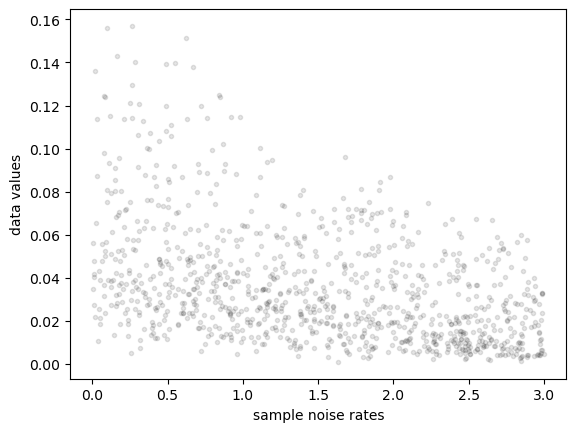

In [71]:
rs = spearmanr(exog_noise, vals_dvgs)[0]
rp = np.corrcoef(exog_noise, vals_dvgs)[0,1]

print('noise-data_vals correlation:')
print('\tspearman: ', rs)
print('\tpearson: ', rp)

plt.figure()
plt.plot(exog_noise, vals_dvgs, 'k.', alpha=0.1)
plt.xlabel('sample noise rates')
plt.ylabel('data values')
plt.show()

rapc pearson corr 0.474704324887999
rapc spearman corr 0.5212801492801493


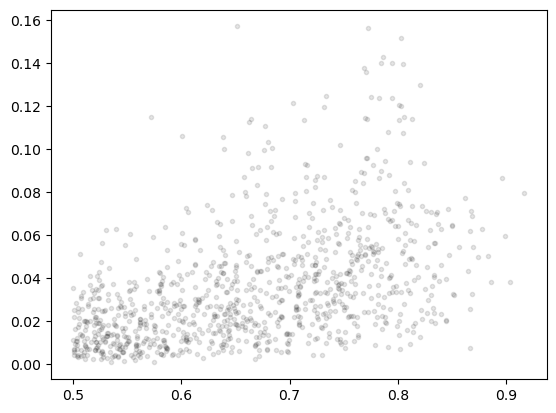

In [72]:
rapc = osig.APC.values[kwargs['idx_train']]

not_nan_idx = (~np.isnan(rapc)).nonzero()[0]

print('rapc pearson corr', np.corrcoef(rapc[not_nan_idx], vals_dvgs[not_nan_idx])[0,1])
print('rapc spearman corr', spearmanr(rapc[not_nan_idx], vals_dvgs[not_nan_idx])[0])

plt.figure() 
plt.plot(rapc, vals_dvgs, 'k.', alpha=0.1)
plt.show()

In [34]:
dvgs_filter_low, dvgs_filter_high = get_filtered_scores(model         = copy.deepcopy(model),
                                                        x_train       = x_train,
                                                        y_train       = y_train,
                                                        x_test        = x_test,
                                                        y_test        = y_test,
                                                        crit          = crit,
                                                        metric        = lambda x,y: r2_score(x,y, multioutput='uniform_average'),
                                                        vals          = vals_dvgs,
                                                        qs            = np.linspace(0., 0.9, 10), 
                                                        batch_size    = 500, 
                                                        lr            = 1e-4, 
                                                        epochs        = 200, 
                                                        repl          = 2, 
                                                        reset_params  = True)

training filtered models... progress: 9/10


In [35]:
dvgs_filter_low

[0.6479693846763033,
 0.6526101610565938,
 0.6554202669345603,
 0.6572570184257382,
 0.6596741840900148,
 0.6614656126833491,
 0.6625200523739856,
 0.6643222742439101,
 0.6641237260670629,
 0.6569814989274361]

In [36]:
rapc_filter_low, rapc_filter_high = get_filtered_scores(model         = copy.deepcopy(model),
                                                        x_train       = x_train,
                                                        y_train       = y_train,
                                                        x_test        = x_test,
                                                        y_test        = y_test,
                                                        crit          = crit,
                                                        metric        = lambda x,y: r2_score(x,y, multioutput='uniform_average'),
                                                        vals          = osig.APC.fillna(-666).values[kwargs['idx_train']],
                                                        qs            = np.linspace(0., 0.9, 10), 
                                                        batch_size    = 500, 
                                                        lr            = 1e-4, 
                                                        epochs        = 200, 
                                                        repl          = 2, 
                                                        reset_params  = True)

KeyboardInterrupt: 

In [38]:
rapc_filter_low

[0.6166761058245978,
 0.617606739405677,
 0.6184987459656727,
 0.6177296218627475,
 0.6184654525129136,
 0.603702188806462,
 0.6055474665314194,
 0.6070438958460193,
 0.6082417239261162,
 0.5984900070486974]

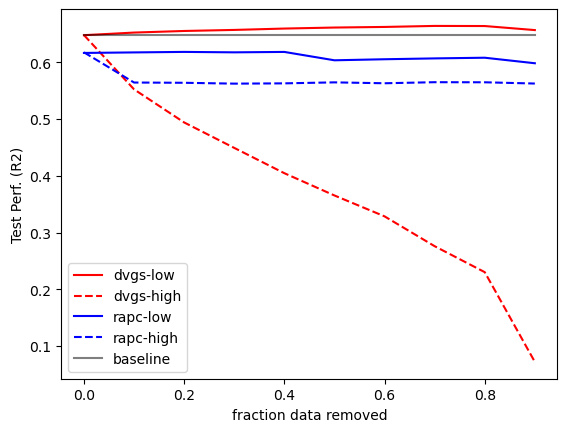

In [44]:
plt.figure()
plt.plot(np.linspace(0., 0.9, 10), dvgs_filter_low, c='r', linestyle='-', label='dvgs-low')
plt.plot(np.linspace(0., 0.9, 10), dvgs_filter_high, c='r', linestyle='--', label='dvgs-high')

plt.plot(np.linspace(0., 0.9, 10), rapc_filter_low, c='b', linestyle='-', label='rapc-low')
plt.plot(np.linspace(0., 0.9, 10), rapc_filter_high, c='b', linestyle='--', label='rapc-high')

plt.plot(np.linspace(0., 0.9, 10), [dvgs_filter_low[0]]*10, color='k', alpha=0.5, label='baseline')
#plt.ylim(0,0.4)
plt.xlabel('fraction data removed')
plt.ylabel('Test Perf. (R2)')
plt.legend()
plt.show()

# DTI prediction 

- filter data based on data values 
- train embedding model 
- use drug embedding to predict DTI (use simple model: logistic?)
- evaluate DTI performance 